# Notebook exercise 2

## 2.1

### Assignment

- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

Show a picture of both your estimations of $I$ and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$</font>.

### Solution

For the first integral, I used the same method as in exercise 1: I generated pseudo-random numbers in the interval $[0,1)$, then evaluated the value of the function at these points, and finally calculated the mean value and the error using data blocking. 

Next, I used importance sampling, which is a technique used to reduce the estimation error. Given a generic integral with a probability distribution $p(x)$, such as $\int g(x) p(x) dx$, a different probability distribution $d(x)$ can be introduced by changing the integrand obtaining 
$$I = \int \left[\frac{g(x) p(x)}{d(x)}\right] d(x).$$
It can be shown that the variance of the integral is reduced by using a function $d(x)$ that has a similar trend to the product $g(x) p(x)$. 

In the integral of this exercise, $p(x) = 1$, and I used $d(x) = 2(1-x)$, which is a Taylor expansion of the integrand function. In the figure below, the two estimates for the integral and the trend of the error are shown, and it is evident that the error for importance sampling is significantly lower, as expected. 

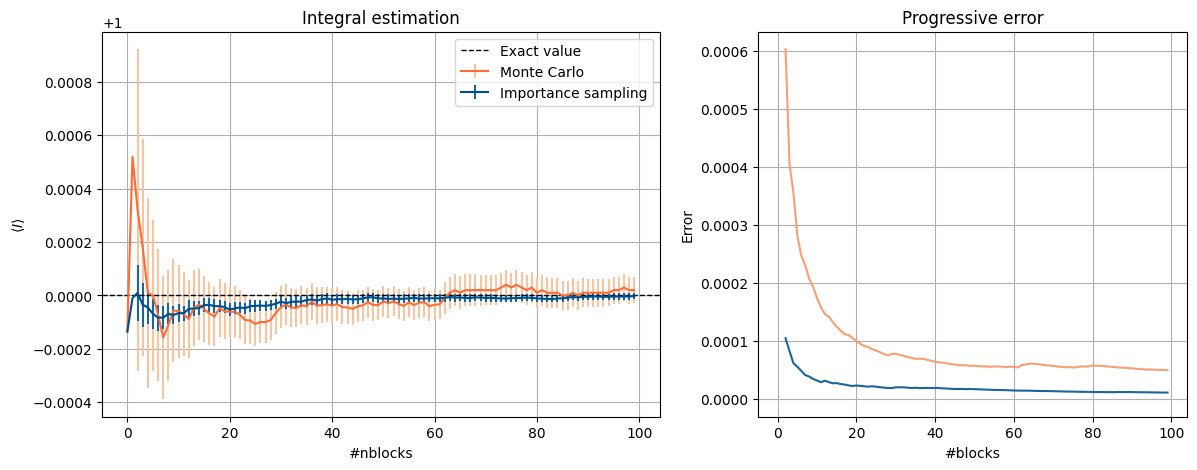

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("data/2.1a.dat")
datab = np.loadtxt("data/2.1b.dat")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1.3, 1]})  

axes[0].errorbar(data[:,0],data[:,1], color='#ff6b35',yerr=data[:,2], linewidth=1.5, ecolor="#f7c59f", elinewidth=1.5, capsize=0, label='Monte Carlo')
axes[0].errorbar(datab[:,0],datab[:,1], yerr=datab[:,2], color="#004e89", linewidth=1.5, ecolor="#1a659e", elinewidth=1.5, capsize=0, label='Importance sampling')
axes[0].set_title(r'Integral estimation')
axes[0].set_xlabel('#nblocks')
axes[0].set_ylabel(r'$\langle I \rangle$')
axes[0].grid(True)
axes[0].axhline(y=1, linestyle='--', color='black', linewidth=1, label ='Exact value')
axes[0].legend()

axes[1].plot(data[:,0], data[:,2], color="#f99e75")
axes[1].plot(datab[:,0], datab[:,2], color="#1a659e")
axes[1].set_title(r'Progressive error')
axes[1].set_xlabel('#blocks')
axes[1].set_ylabel(r'Error')
axes[1].grid(True)


## 2.2

### Assignment

- <span style="color:red">3D Random Walks (RW) on a cubic lattice and in the continuum:</span> Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Suggestion: divide your $M$ throws into a reasonable number of blocks, compute $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ as function of the step $i\in [0,10^2]$ in each block and use these values (for fixed $i$) to obtain the average value and its statistical uncertainty.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

### Solution

In order to implement the two types of Random Walk (RW), I constructed a class called position. The private variable of this class is a ```vec``` from the ```Armadillo``` library, which contains the coordinates of the point. This class also provides two functions:
```c++
void position:: next_s(Random &r, double l_s){
  double step = l_s; //step length
  double theta = acos(2*r.Rannyu() - 1); 
  double phi = 2 * M_PI * r.Rannyu();
  vec a = {step*sin(theta)*cos(phi), step*sin(theta)*sin(phi), step*cos(theta)};
  pos += a; // Update position by adding the step vector
}

void position::next_s_discrete(Random &r, double l_s) {
  int k = int(r.Rannyu(0,6));
  int axis = k / 2;       
  int direction = (k % 2 == 0) ? 1 : -1; 
  pos(axis) += direction * l_s; // Update position by adding or subtracting l_s along the chosen axis
}
```
which allow the coordinates of the point to be updated according to the two different types of RW. Then, I evaluate the distance $d = \sqrt{\langle |\vec{r}N|^2 \rangle_{RW}}$ of the RW from the starting position. I used $10^4$ random walks with $10^2$ steps each. To evaluate the mean value, I used data blocking with $10^2$ blocks. In the next figure, the distance as a function of the number of steps is shown for both types of RW. I also fitted both trends as suggested in the assignment, and I found good agreement with the expected diffusive behavior.

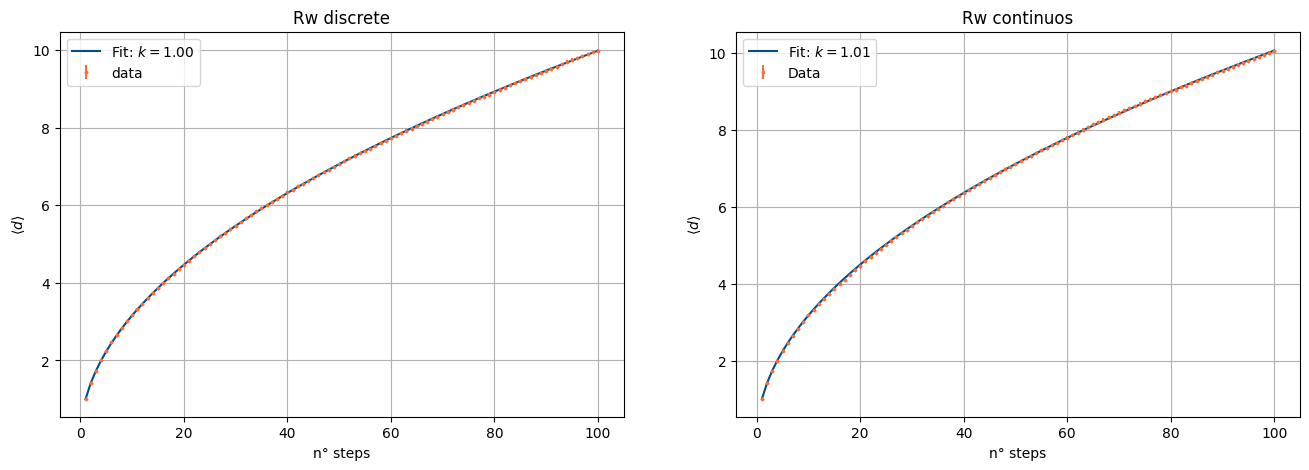

In [7]:
from scipy.optimize import curve_fit

def root(x, a):
    return a * np.sqrt(x)

rw_d = np.loadtxt("data/es2.2_d.dat")
rw_c = np.loadtxt("data/es2.2_c.dat")

x = np.arange(0, 100, 1)


#fitting of dataset
popt_d, pcov_d = curve_fit(root, rw_d[:,0], rw_d[:,1])
a_d = popt_d[0]
popt_c, pcov_c = curve_fit(root, rw_c[:,0], rw_c[:,1])
a_c = popt_c[0]


#plotting of dataset
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  

y_fd = root(rw_d[:,0], a_d)
axes[0].plot(rw_d[:,0], y_fd, color='#004e89', linewidth=1.5,label=f'Fit: $k={a_d:.2f}$')
axes[0].errorbar(rw_d[:,0],rw_d[:,1], color='#ff6b35', fmt='D', ms=1.5, yerr=rw_d[:,2], ecolor='#ff6b35', capsize=0, label='data')
axes[0].set_title(r'Rw discrete')
axes[0].set_xlabel('n° steps')
axes[0].set_ylabel(r'$\langle d \rangle$')
axes[0].grid(True)
axes[0].legend()

y_fc = root(rw_c[:,0], a_c)
axes[1].plot(rw_c[:,0], y_fc, color='#004e89', linewidth=1.5,label=f'Fit: $k={a_c:.2f}$')
axes[1].errorbar(rw_c[:,0], rw_c[:,1], color='#ff6b35', fmt='D', ms=1.5, yerr=rw_c[:,2], ecolor='#ff6b35', capsize=0, label='Data')
axes[1].set_title(r'Rw continuos')
axes[1].set_xlabel('n° steps')
axes[1].set_ylabel(r'$\langle d \rangle$')
axes[1].grid(True)  
axes[1].legend()

plt.show()